# Bank Sentiment Analysis Example

Example modified from: 

- Dataset: https://www.kaggle.com/datasets/dhavalrupapara/banks-customer-reviews-dataset
- Notebook: https://www.kaggle.com/code/tanshihjen/sentimentanalysis-bankreviewsdataset

## Upload data into Vast DB via VMS UI

NOTE: VMS UI load requires Vast Data 5.3+

- Navigate to the VMS
- Open Database, Schema
- Click Upload File
- Upload `bank_reviews.csv`


In [1]:
# Update these values to match the values above

DATABASE_NAME = "csnow-db"
SCHEMA_NAME = "sentiment_analysis"
TABLE_NAME = "bank_reviews"

## Download data using Vast DB Python SDK

In [2]:
import os

VASTDB_ENDPOINT = os.getenv("VASTDB_ENDPOINT")
VASTDB_ACCESS_KEY = os.getenv("VASTDB_ACCESS_KEY")
VASTDB_SECRET_KEY = os.getenv("VASTDB_SECRET_KEY")

In [3]:
import pyarrow as pa
import vastdb

session = vastdb.connect(
    endpoint=VASTDB_ENDPOINT,
    access=VASTDB_ACCESS_KEY,
    secret=VASTDB_SECRET_KEY)

with session.transaction() as tx:
    bucket = tx.bucket(DATABASE_NAME)
    schema = bucket.schema(SCHEMA_NAME)
    table = schema.table(TABLE_NAME)

    result = table.select().read_all()
    # print(result)
    print(f"Number of records read: {result.num_rows}")

    sentiment_df = result.to_pandas()

Number of records read: 1000


## Exploratory Analysis

In [4]:
# import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [5]:
# load the dataset
data = sentiment_df

# check the dimension of the dataset
print(data.shape)

# view the first 5 rows of the dataset
data.head()

(1000, 10)


,author,date,address,bank,rating,review_title_by_user,review,bank_image,rating_title_by_user,useful_count
0,AMRENDRA T,"Mar 21, 2020",New delhi,SBI,4.0,"""Best saving""",State Bank Of India is located nearby in our a...,https://static.bankbazaar.com/images/common/ba...,Great!,133
1,BISHWA,"Mar 20, 2020",Kolkata,SBI,5.0,"""Good service""","I have my salary account in SBI, when I applie...",https://static.bankbazaar.com/images/common/ba...,Blown Away!,89
2,SANTOSH,"Mar 20, 2020",Hooghly,Axis Bank,5.0,"""Excellent Service""",I am using Axis bank saving account for the p...,https://static.bankbazaar.com/images/common/ba...,Blown Away!,48
3,MAHADEV,"Mar 20, 2020",Pune,HDFC Bank,5.0,"""Excellent service""",I have my salary bank account in HDFC bank for...,https://static.bankbazaar.com/images/common/ba...,Blown Away!,52
4,R,"Mar 20, 2020",Bangalore,review,5.0,"""Good account""","Close to around 10 years, I am holding this Co...",https://static.bankbazaar.com/images/common/ba...,Blown Away!,22


#### Attributes Description:

1. author - The user who authored the review, providing valuable insights into the reviewer's identity and perspective.
2. date - The date when the review was submitted, offering a temporal dimension to the dataset and enabling time-based analysis.
3. address - The geographical location from which the review was written, contributing to understanding regional trends and variations in banking experiences.
4. bank - The name of the reviewed bank, serving as a key identifier for the financial institution being assessed.
5. rating - The user's numerical assessment of the bank's service, indicating user satisfaction on a numerical scale.
6. review_titile_by_user - The user-assigned title to their review, summarizing the essence of their feedback in a concise manner.
7. review - The detailed content of the user's review about the bank, providing the primary textual data for analysis and insights.
8. bank_image - The URL pointing to the bank's logo or image relevant to the review, facilitating visual associations with the bank.
9. rating_title_by_user - The user-assigned title to their rating, potentially offering additional context to the rating value.
10. useful_count - The count of users who found the review helpful, reflecting the impact and usefulness of the review among other users.

In [6]:
# top level overview of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   author                1000 non-null   object 
 1   date                  1000 non-null   object 
 2   address               1000 non-null   object 
 3   bank                  1000 non-null   object 
 4   rating                1000 non-null   float64
 5   review_title_by_user  1000 non-null   object 
 6   review                1000 non-null   object 
 7   bank_image            1000 non-null   object 
 8   rating_title_by_user  1000 non-null   object 
 9   useful_count          1000 non-null   int64  
dtypes: float64(1), int64(1), object(8)
memory usage: 78.3+ KB


In [7]:
# remove columns that are not using for analysis
# columns to remove: ['author', 'date', 'bank_image']

data.drop(columns=['author', 'date', 'bank_image'], axis=1, inplace=True)

In [8]:
# total number of bank and address in the dataset

numAddress = data['address'].nunique()
numBank = data['bank'].nunique()

print(f'The reviews are collected from {numBank} different banks that located around {numAddress} of places in India.')
print('These banks are: ', data.bank.unique())

The reviews are collected from 10 different banks that located around 107 of places in India.
These banks are:  ['SBI' 'Axis Bank' 'HDFC Bank' 'review' 'IDBI' 'Kotak' 'IndusInd Bank'
 'Canara Bank' 'Citibank' 'Punjab National Bank']


In [9]:
# some of the data without 'bank' name and is named as 'review' in the dataset
# convert these data to 'Unknown'

data['bank'] = data['bank'].replace('review', 'Unknow')

#### Question: Which are the top 10 places where the reviews are collected from?

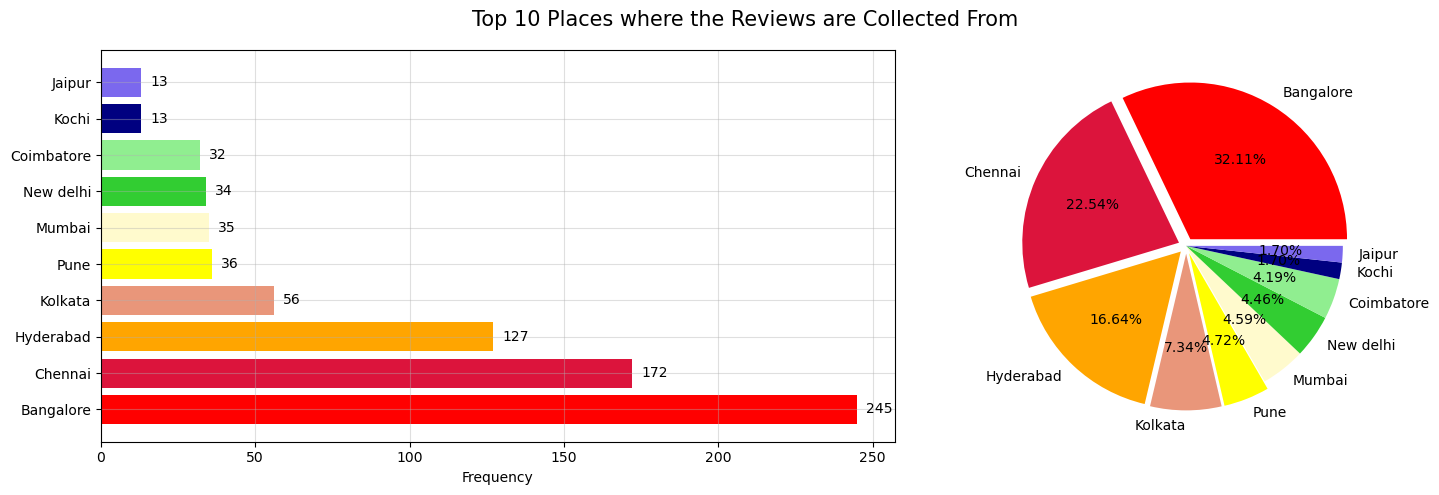

In [10]:
# distribution of the column 'address'
address = data['address'].value_counts().sort_values(ascending=False)[:10]

colors = ['red','crimson','orange','darksalmon','yellow','lemonchiffon','limegreen','lightgreen','navy','mediumslateblue']
explodes = ([0.05]*5) + ([0]*5)

# visualization (top 10 places where the reviews are collected from)
figure, axes = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios':[1.5,1]})
axes[0].barh(y=address.index, width=address.values, color=colors)
axes[0].set_xlabel('Frequency')

for index, values in enumerate (address):
    axes[0].text(values+3, index, str(values), va='center')

axes[0].grid(alpha=0.4)
axes[1].pie(address.values, labels=address.index, autopct='%.2f%%', explode=explodes, colors=colors)
figure.suptitle('Top 10 Places where the Reviews are Collected From', fontsize=15)
plt.tight_layout()
plt.show()

#### Question: Which bank has the highest number of reviews?

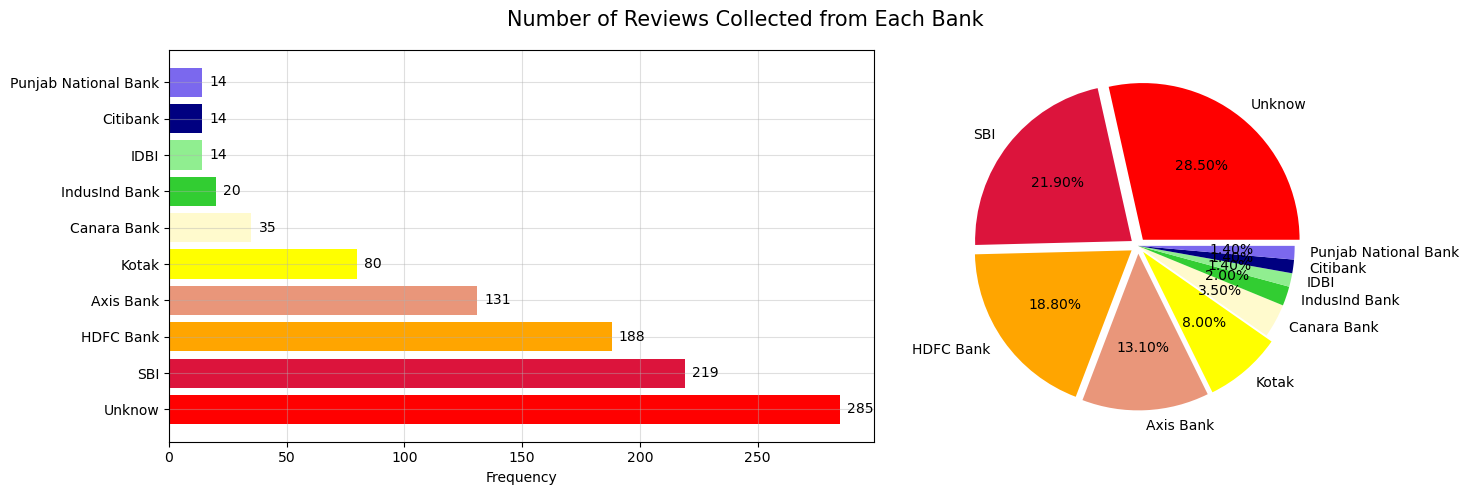

In [11]:
# distribution of the data by 'bank'
bank = data['bank'].value_counts().sort_values(ascending=False)

# visualization in bar chart and pie chart
figure, axes = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios':[1.5,1]})
axes[0].barh(y=bank.index, width=bank.values, color=colors)
axes[0].set_xlabel('Frequency')

for index, values in enumerate (bank):
    axes[0].text(values+3, index, str(values), va='center')

axes[0].grid(alpha=0.4)
axes[1].pie(bank.values, labels=bank.index, autopct='%.2f%%', explode=explodes, colors=colors)
figure.suptitle('Number of Reviews Collected from Each Bank', fontsize=15)
plt.tight_layout()
plt.show()

#### Question: What is the overall distribution of rating in 1000 reviews regardless of the bank and the location?

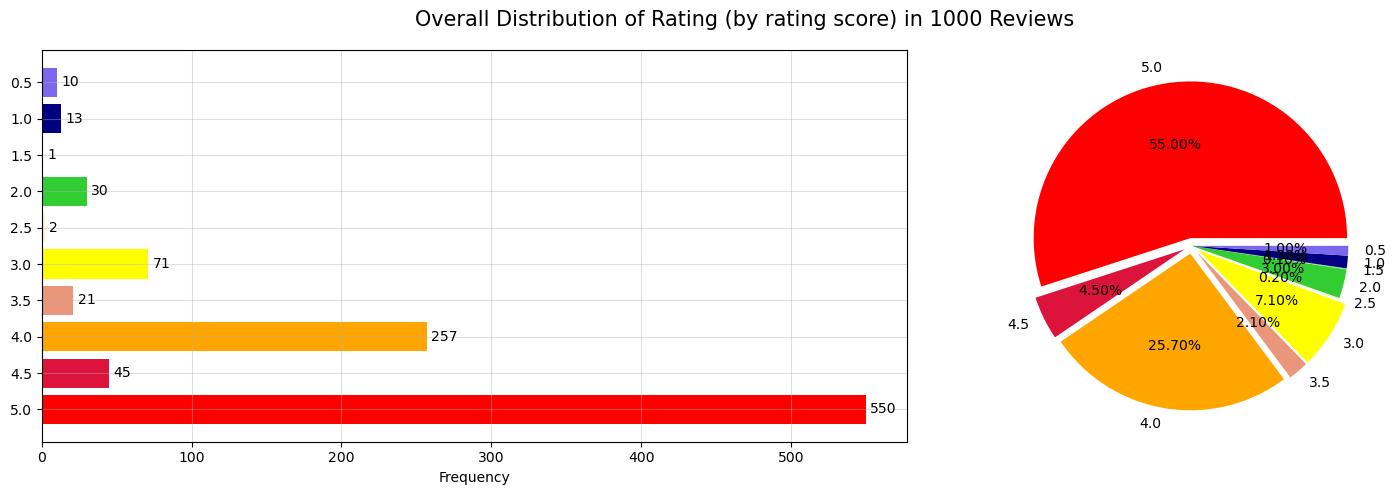

In [12]:
# distribution of rating (by rating score)
# convert the rating from int to str
data_copy = data.copy()
data_copy['rating'] = data_copy['rating'].astype(str)

rating = data_copy['rating'].value_counts().sort_index(ascending=False)

# visualization in bar chart and pie chart
figure, axes = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios':[1.5,1]})
axes[0].barh(y=rating.index, width=rating.values, color=colors)
axes[0].set_xlabel('Frequency')

for index, values in enumerate (rating):
    axes[0].text(values+3, index, str(values), va='center')

axes[0].grid(alpha=0.4)
axes[1].pie(rating.values, labels=rating.index, autopct='%.2f%%', explode=explodes, colors=colors)
figure.suptitle('Overall Distribution of Rating (by rating score) in 1000 Reviews', fontsize=15)
plt.tight_layout()
plt.show()

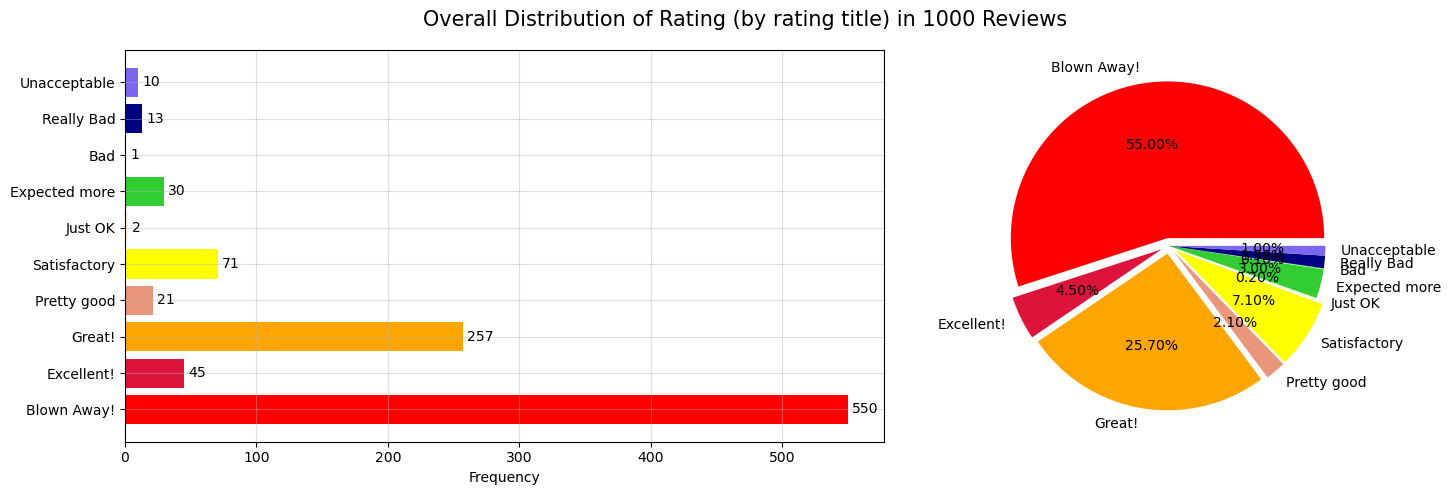

In [13]:
# distribution of rating (by rating title)
rating_order = ['Unacceptable','Really Bad','Bad','Expected more','Just OK','Satisfactory','Pretty good','Great!','Excellent!','Blown Away!']
rating_title = data['rating_title_by_user'].value_counts(sort=False).reindex(rating_order)
reversed_rating_title = rating_title[::-1]

# visualization in bar chart and pie chart
figure, axes = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios':[1.5,1]})
axes[0].barh(y=reversed_rating_title.index, width=reversed_rating_title.values, color=colors)
axes[0].set_xlabel('Frequency')

for index, values in enumerate (reversed_rating_title):
    axes[0].text(values+3, index, str(values), va='center')

axes[0].grid(alpha=0.4)
axes[1].pie(reversed_rating_title.values, labels=reversed_rating_title.index, autopct='%.2f%%', explode=explodes, colors=colors)
figure.suptitle('Overall Distribution of Rating (by rating title) in 1000 Reviews', fontsize=15)
plt.tight_layout()
plt.show()

#### Question: What is the most common vocabulary used by the user in their review title?

In [14]:
! pip install -q wordcloud

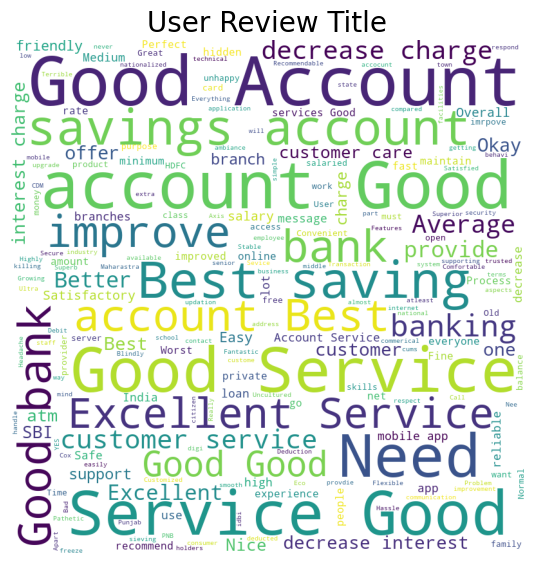

In [15]:
from wordcloud import WordCloud

combined_title = ' '.join(data['review_title_by_user'])


# create a word cloud using the combined text
wordcloud_title = WordCloud(width = 800, height = 800,
                            background_color ='white',
                            min_font_size = 10).generate(combined_title)

# plot the WordCloud image
plt.figure(figsize=(6,6))
plt.imshow(wordcloud_title)
plt.axis('off')
plt.title('User Review Title', fontsize=20)
plt.tight_layout(pad=2)
plt.show()

#### Question: Can we help the those bank that rated 2.5 score and below to improve? Perhaps the word cloud can provide some insights.

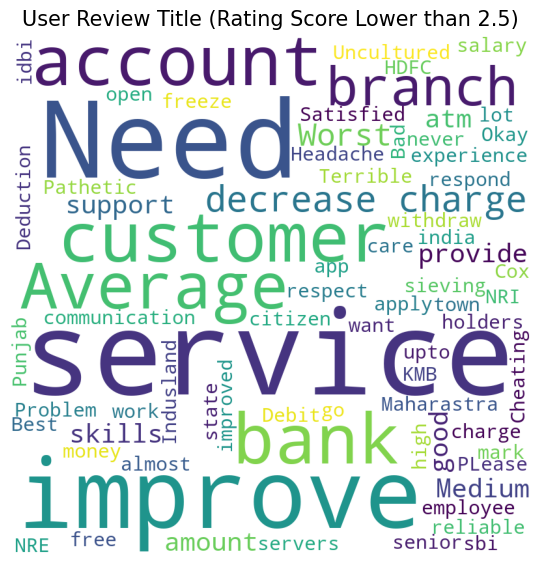

In [16]:
# subset the data that rating score is 2.5 and lower
data_copy = data.copy()
data_copy = data[data['rating']<=2.5]

combined_title_lowrate = ' '.join(data_copy['review_title_by_user'])


# create a word cloud using the combined text
wordcloud_lowrate = WordCloud(width = 800, height = 800,
                            background_color ='white',
                            min_font_size = 10).generate(combined_title_lowrate)

# plot the WordCloud image
plt.figure(figsize=(6,6))
plt.imshow(wordcloud_lowrate)
plt.axis('off')
plt.title('User Review Title (Rating Score Lower than 2.5)', fontsize=15)
plt.tight_layout(pad=2)
plt.show()

## Perform sentiment analysis

In [17]:
! pip install -q nltk

In [18]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

# initialize the object of SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [19]:
# calculate the polarity scores of the review
data['polarity'] = data['review'].apply(sia.polarity_scores)
data['compound'] = data['polarity'].apply(lambda x: x.get('compound'))

In [25]:
# define a function to perform the sentiment categorization
def categorize(score):
    if score < 0:
        return 'To be Improved'
    elif score > 0.5:
        return 'Blown Away'
    else:
        return 'Neutral'

In [26]:
# insert a new column 'Sentiment_Category' by categorized the sentiment based on the compound score
data['Sentiment_Category'] = data['compound'].apply(categorize)

# view the first 5 rows of the data after new columns inserted
data.head()

,address,bank,rating,review_title_by_user,review,rating_title_by_user,useful_count,polarity,compound,Sentiment_Category
0,New delhi,SBI,4.0,"""Best saving""",State Bank Of India is located nearby in our a...,Great!,133,"{'neg': 0.0, 'neu': 0.876, 'pos': 0.124, 'comp...",0.7264,Blown Away
1,Kolkata,SBI,5.0,"""Good service""","I have my salary account in SBI, when I applie...",Blown Away!,89,"{'neg': 0.0, 'neu': 0.875, 'pos': 0.125, 'comp...",0.7165,Blown Away
2,Hooghly,Axis Bank,5.0,"""Excellent Service""",I am using Axis bank saving account for the p...,Blown Away!,48,"{'neg': 0.08, 'neu': 0.785, 'pos': 0.135, 'com...",0.4588,Neutral
3,Pune,HDFC Bank,5.0,"""Excellent service""",I have my salary bank account in HDFC bank for...,Blown Away!,52,"{'neg': 0.042, 'neu': 0.849, 'pos': 0.108, 'co...",0.5267,Blown Away
4,Bangalore,Unknow,5.0,"""Good account""","Close to around 10 years, I am holding this Co...",Blown Away!,22,"{'neg': 0.0, 'neu': 0.837, 'pos': 0.163, 'comp...",0.7357,Blown Away


##### Let's get some insights from the negative sentiments.

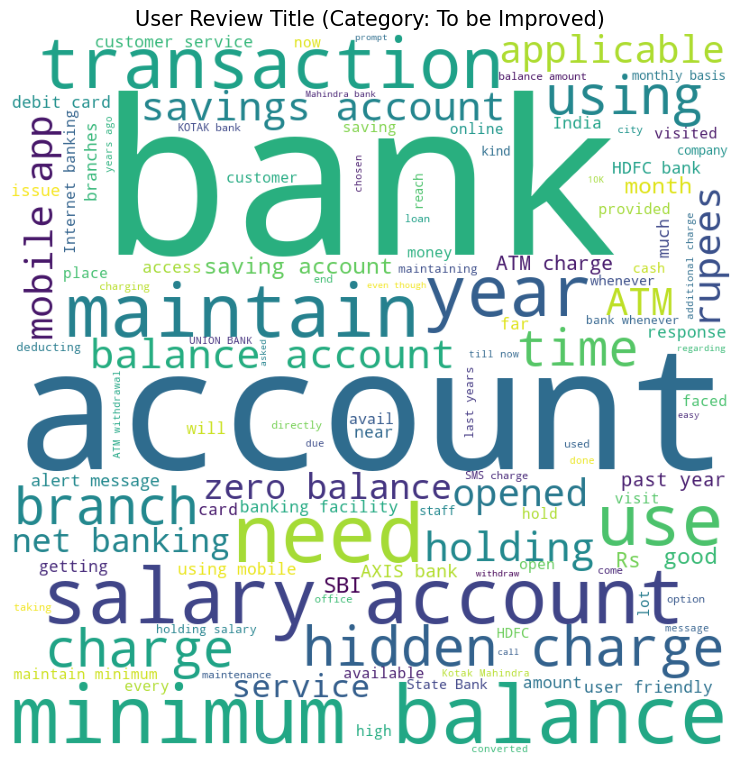

In [27]:
data_copy = data.copy()
data_copy = data[data['Sentiment_Category']=='To be Improved']

combined_tobeImproved = ' '.join(data_copy['review'])


# create a word cloud using the combined text
wordcloud_tobeImproved = WordCloud(width = 800, height = 800,
                            background_color ='white',
                            min_font_size = 10).generate(combined_tobeImproved)

# plot the WordCloud image
plt.figure(figsize=(8,8))
plt.imshow(wordcloud_tobeImproved)
plt.axis('off')
plt.title('User Review Title (Category: To be Improved)', fontsize=15)
plt.tight_layout(pad=2)
plt.show()

##### Let's remove the regular expression and some common words in the review from the negative sentiments.

In [28]:
import re

common_words = ['bank', 'account','salary','saving','savings','rupees']

pattern = re.compile(r'\b(?:' + '|'.join(map(re.escape, common_words)) + r')\b', flags=re.IGNORECASE)
filtered_string = pattern.sub('', combined_tobeImproved)

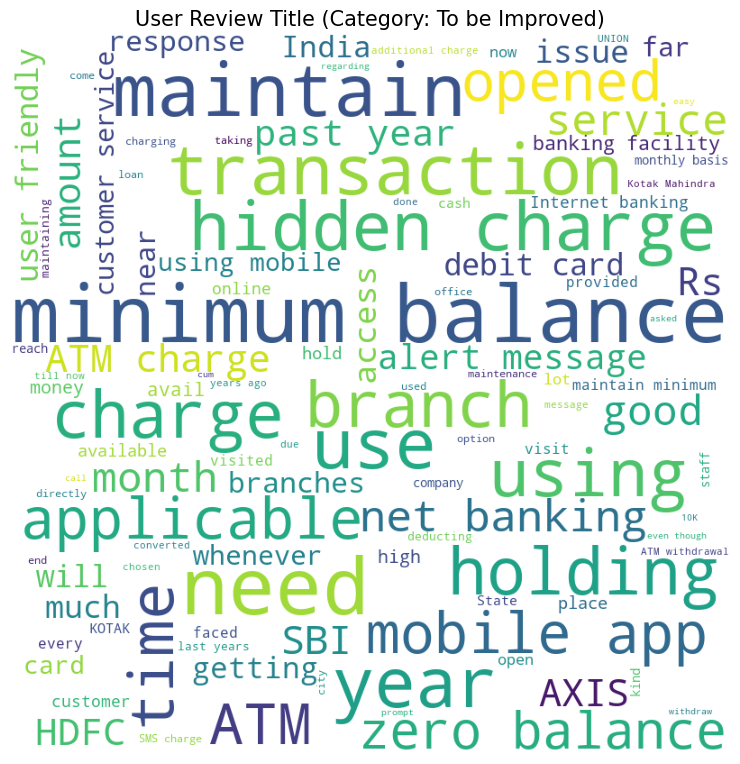

In [29]:
# create a word cloud using the combined text
wordcloud_tobeImproved = WordCloud(width = 800, height = 800,
                            background_color ='white',
                            min_font_size = 10).generate(filtered_string)

# plot the WordCloud image
plt.figure(figsize=(8,8))
plt.imshow(wordcloud_tobeImproved)
plt.axis('off')
plt.title('User Review Title (Category: To be Improved)', fontsize=15)
plt.tight_layout(pad=2)
plt.show()

#### Summary:
In conducting sentiment analysis and visualizing the results through a word cloud, notable keywords emerged in negative reviews. Common issues highlighted by customers include concerns about minimum balance requirements, hidden charges, ATM fees, and aspects related to customer service. These key themes provide valuable insights into areas that may require attention and improvement for a more positive customer experience.